In [1]:
import os
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
from torchvision import transforms, datasets, models
from datetime import datetime
from tensorboardX import SummaryWriter
from utils import get_lr
from download_images import PATH, TRAIN_PATH, VALID_PATH

BATCH_SIZE = 64
NUM_WORKERS = 8
IMG_SIZE = 224
NORM_MEAN = [0.485, 0.456, 0.406]
NORM_STD = [0.229, 0.224, 0.225]

random_choice_transform = transforms.RandomChoice(
    [
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.3),
        transforms.ColorJitter(contrast=0.3),
        transforms.ColorJitter(saturation=0.3),
        transforms.RandomGrayscale(p=0.5),
    ]
)

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        random_choice_transform,
        transforms.ToTensor(),
        transforms.Normalize(NORM_MEAN, NORM_STD)
    ]),
    'valid': transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(NORM_MEAN, NORM_STD)
    ])
}

data = {
    'train': datasets.ImageFolder(root=TRAIN_PATH, transform=data_transforms['train']),
    'valid': datasets.ImageFolder(root=VALID_PATH, transform=data_transforms['valid'])
}

train_loader = DataLoader(data['train'], batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=True)
valid_loader = DataLoader(data['valid'], batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=False)


In [2]:
classes_name = data['train'].classes
classes_count = len(classes_name)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# inputs, classes = next(iter(train_loader))
# imshow(inputs[3].cpu().numpy())

In [3]:
def imshow(img):
    img = np.transpose(img, (1, 2, 0))
    mean = np.array(NORM_MEAN)
    std = np.array(NORM_STD)
    img = std * img + mean
    img = np.clip(img, 0, 1)
    plt.imshow(img)

In [4]:
model = models.resnet50(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, classes_count)
model.load_state_dict(torch.load(os.path.join('./models', 'model_resnet50_19-02-2020.pt')))
model = model.to(device)

In [5]:
valid_acc = 0
correct, total = 0, 0
true_pred = []
false_pred = []
acc_per_class = [[] for i in range(classes_count)]

model.eval()
with torch.no_grad():
    for images, labels in valid_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        images = images.cpu().numpy()

        _, pred = torch.max(outputs.data, 1)
        correct += torch.sum(pred == labels)
        
        total += labels.size(0)
        valid_acc = float(100.0 * correct) / total
        
        for i in range(labels.size(0)):
            if pred[i] == labels[i]:
                acc_per_class[labels[i]].append(1)
                true_pred.append([images[i], pred[i], labels[i]])
            else:
                acc_per_class[labels[i]].append(0)
                false_pred.append([images[i], pred[i], labels[i]])

In [6]:
mean_acc = 0
total = 0
for i in range(classes_count):
    acc = np.sum(acc_per_class[i])/len(acc_per_class[i])
    total += len(acc_per_class[i])
    mean_acc += np.sum(acc_per_class[i])
    print("{} {} ({}/{})".format(np.round(acc, 2), classes_name[i], np.sum(acc_per_class[i]), len(acc_per_class[i])))

print("mean accuracy: {} ({}/{})".format(np.round(mean_acc/total, 2), correct, total))

0.99 DMP_BRAND_STOYKA (141/143)
0.96 DMP_BRAND_XO (65/68)
0.62 DMP_PALLETA (24/39)
0.75 KOROB (43/57)
0.94 OMP (244/260)
mean accuracy: 0.91 (517/567)


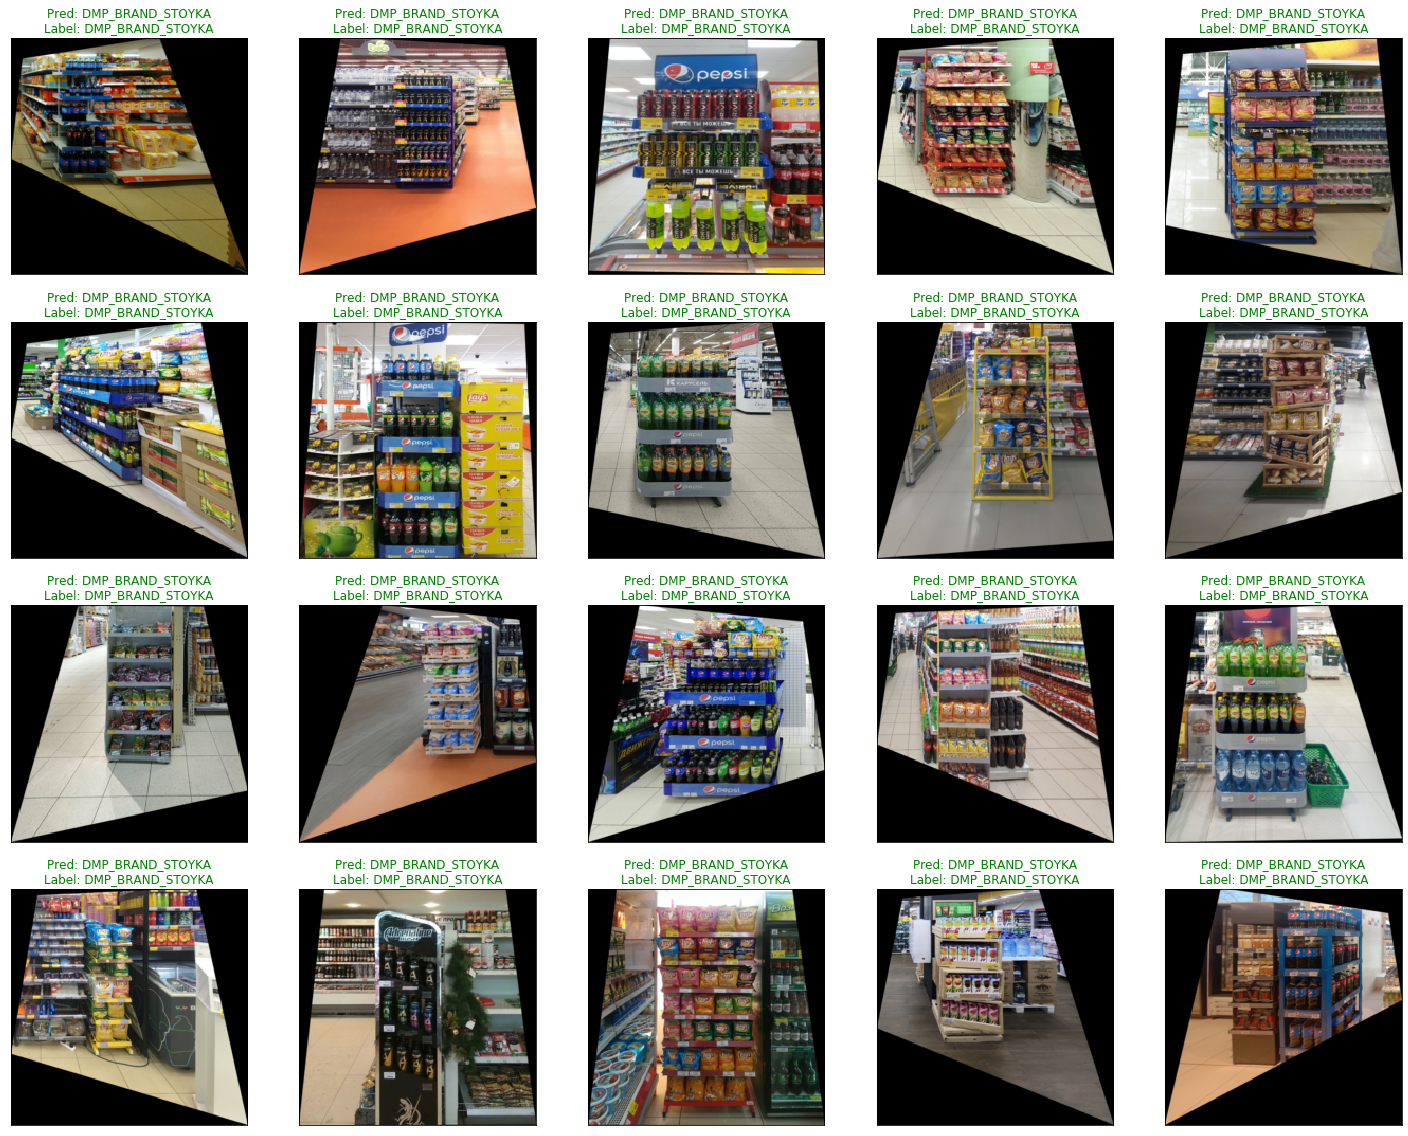

In [7]:
fig = plt.figure(figsize=(25, 20))
st = 20
data = true_pred[st:st+20]
count_imgs = len(data)
for idx in range(count_imgs):
    ax = fig.add_subplot(4, count_imgs/4, idx+1, xticks=[], yticks=[])
    imshow(data[idx][0])
    ax.set_title("Pred: {}\nLabel: {}".format(classes_name[data[idx][1]], classes_name[data[idx][2]]),
                 color=("green" if data[idx][1]==data[idx][2] else "red"))